# Train ANN with Augmented Data

Copyright © 2023 State of California, Department of Water Resources. University of California, Davis. All Rights Reserved. 

This script is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 

Reproduction or distribution of this script without permission is prohibited. 

Contact: Zhaojun Bai (zbai@ucdavis.edu); Kevin He (kevin.he@water.ca.gov)

## Define Hyper-Parameters

In [ ]:
####################################################
############## Hyper-param definitions #############
####################################################

''' 
Select NN architecture from:
MLP, LSTM, GRU, ResNet, Res-LSTM, Res-GRU, Transformer
'''
model_type ='Res-LSTM'

''' 
Dropout ratio at (before) the input layer
'''
input_dropout = 0.

''' 
Dropout ratio at intermediate layers
'''
intermediate_dropout = 0

''' 
Numbers of neurons in the main branch
 - Provide two numbers for MLP, ResNet, Res-LSTM, Res-GRU, 
 - Provide one number for LSTM, GRU.
 '''
num_neurons_multiplier=[8, 2]

'''
Number of training epochs (Note: training will stop when reaching this number 
or test loss doesn't decrease for 50 epochs)
'''
epochs = 1

'''Give a name to current train/test combination'''
scenario_name = 'Tune_RSAC_RSAN'

'''
Lists of training and validation sets
'''
train_data = ["dsm2_ann_inputs_rsacminus15day.xlsx",
              "dsm2_ann_inputs_rsacminus20pct.xlsx",
              "dsm2_ann_inputs_rsacplus15day.xlsx",
              "dsm2_ann_inputs_rsacplus20pct.xlsx",
              "dsm2_ann_inputs_rsanminus15day.xlsx",
              "dsm2_ann_inputs_rsanminus20pct.xlsx",
              "dsm2_ann_inputs_rsanplus15day.xlsx",
              "dsm2_ann_inputs_rsanplus20pct.xlsx",
              ]
val_data = "dsm2_ann_inputs_base.xlsx"

'''
Dictionary of test sets
- keys: test scenario name
- values: names of excel files
'''
test_data = {'dcc0':"dsm2_ann_inputs_dcc0.xlsx",
             'smscg1':"dsm2_ann_inputs_smscg1.xlsx",
             'dcc1':"dsm2_ann_inputs_dcc1.xlsx",
             'smscg0':"dsm2_ann_inputs_smscg0.xlsx"}

'''
Dictionary of extra test set(s)
- keys: test scenario name
- values: names of excel files
'''
extra_data = {'observed': "observed_data_daily.xlsx"}

'''
Ratio to split the extra dataset for test
'''
extra_data_test_ratio = 0.3
'''
Which part of extra dataset used for for test
Available options: {'first', 'last', 'middle', 'manual'}
'''
which_part_for_test = 'last'

'''Whether to print detailed metrics (std, MSE, ...) for key stations'''
print_detailed_key_station_metrics = False

''' 
Whether to (True) train models from scratch or (False) evaluate pre-trained models
'''
train_models = True

'''Whether to save evaluation results (metric values, figures) to Google Drive'''
save_results = True

############################################
############  Siyu's Notes:  ###############
############################################
'''
In the pickle file, numerical results will be saved with the following suffixes:
-- Training results (listed in train_data): '_train'
-- Test results (listed in test_data): '_test'
-- Validation results (defined by val_data): '_val'
-- Results on chronologically-split observed data (defined by extra_data, sliced by valid_slice): '_observed'
'''




####################################################
########## End of hyper-param definitions ##########
####################################################
initial_lr=0.001

'''
Define the model architecture: (input layer will be build automatically)

Supported abbreviation-layer pairs (detailed definitions can be found in "Layer builders" section)
- 'lstm': keras.layers.LSTM
- 'res': resnet block (basic_1d)
- 'c1d': keras.layers.Conv1D
- 'td': keras.layers.TimeDistributed
- 'dr': keras.layers.Dropout
- 'f': keras.layers.Flatten
- 'g': keras.layers.GRU
- 'd': keras.layers.Dense 
- 'o': keras.layers.Dense

Usage of resnet blocks: res(num_of_filters)x(kernel_size)x(stride)x(stages)
stages: # of resnet units in the block
example: model_str_def = 'res10x3x1x1_f_d8_d2_o1'

Usage of 1D conv layers: c1d(num_of_filters)x(kernel_size)x(stride)
example: model_str_def = 'c1d10x3x1_c1d10x3x1_f_d8_d2_o1'

'''
# Note: numbers following 'd' or 'o' will be multiplied by [size of output] before being used as numbers of neurons in dense layer
model_type = model_type.lower()

if model_type =='mlp':
    ## 1. MLP Network
    model_str_def = '%sd%d_%sd%d_o1' % (('dr%.2f_' % input_dropout if input_dropout > 0 else ''),
                                        num_neurons_multiplier[0],
                                        ('dr%.2f_' % intermediate_dropout if intermediate_dropout > 0 else ''),
                                        num_neurons_multiplier[1])

elif model_type =='lstm':
    # 2. LSTM Network
    model_str_def = '%slstm%d_%sf_o1' % (('dr%.2f_' % input_dropout if input_dropout > 0 else ''),
                                         num_neurons_multiplier[0],
                                         ('dr%.2f_' % intermediate_dropout if intermediate_dropout > 0 else ''),)

elif model_type =='gru':
    # 3. GRU Network
    model_str_def = '%sg%d_%sf_o1' % (('dr%.2f_' % input_dropout if input_dropout > 0 else ''),
                                    num_neurons_multiplier[0],
                                    ('dr%.2f_' % intermediate_dropout if intermediate_dropout > 0 else ''),)

elif model_type =='resnet':
    # 4. ResNet
    if intermediate_dropout > 0:
        num_neurons_multiplier.insert(1,'dr%.2f' % intermediate_dropout)
    model_str_def = '%sresnet%s' % (('dr%.2f_' % input_dropout if input_dropout > 0 else ''),
                                    '_' + '_'.join([str(ii) for ii in num_neurons_multiplier]))
    num_res_blocks=1

elif model_type =='res-lstm':
    # 5. Res-LSTM
    if intermediate_dropout > 0:
        num_neurons_multiplier.insert(1,'dr%.2f' % intermediate_dropout)
    model_str_def = '%sresidual_lstm%s' % (('dr%.2f_' % input_dropout if input_dropout > 0 else ''),
                                        '_' + '_'.join([str(ii) for ii in num_neurons_multiplier]))

elif model_type =='res-gru':
    # 6. Res-GRU
    if intermediate_dropout > 0:
        num_neurons_multiplier.insert(1,'dr%.2f' % intermediate_dropout)
    model_str_def = '%sresidual_gru%s' % (('dr%.2f_' % input_dropout if input_dropout > 0 else ''),
                                        '_' + '_'.join([str(ii) for ii in num_neurons_multiplier]))

elif model_type =='transformer':
    # 7. Transformer
    model_str_def = '%stransformer' % ('dr%.2f_' % input_dropout if input_dropout > 0 else '')
else:
    raise "Model %s is not supported" % model_type

'''
Define parameters for input pre-processing
- ndays: number of daily values in inputs
- window_size: length of averaging windows
- nwindows: number of moving averages
'''
if model_type =='mlp':
    # apply pre-defined average windowing:
    ndays=8
    window_size=11
    nwindows=10
else:
    # directly use daily measurements as inputs
    ndays=118
    window_size=0
    nwindows=0


# manually picked years for "training" in observed dataset
# if which_part_for_test == 'manual', years not listed below will be used 
# for testing and results will be saved with '_observed' suffix in the 
# pickle file
picked_training_years = [('1990-10-1','1991-9-30'),
                         ('1992-10-1','1995-9-30'),
                         ('1996-10-1','1998-9-30'),
                         ('1999-10-1','2003-9-30'),
                         ('2004-10-1','2006-9-30'),
                         ('2007-10-1','2010-9-30'),
                         ('2011-10-1','2013-9-30'),
                         ('2014-10-1','2016-9-30'),
                         ('2017-10-1','2019-9-30'),]


# percentile thresholds for ranged results
percentiles = [0,0.75,0.95]  

## Install Packages

In [ ]:
import os
import sys
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import layers
#import keras


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


## Read Data

In [ ]:
google_drive_dir = 'DWR_Workshop'
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
gdrive_root_path = os.path.join('/content/drive','My Drive',google_drive_dir)
sys.path.append(gdrive_root_path)
import annutils

Mounted at /content/drive


In [ ]:
observed_stations_ordered_by_median = ['RSMKL008', 'RSAN032', 'RSAN037', 'RSAC092', 'SLTRM004', 'ROLD024',
                                           'CHVCT000', 'RSAN018', 'CHSWP003', 'CHDMC006', 'SLDUT007', 'RSAN072',
                                           'OLD_MID', 'RSAN058', 'ROLD059', 'RSAN007', 'RSAC081', 'SLMZU025',
                                           'RSAC075', 'SLMZU011', 'SLSUS012', 'SLCBN002', 'RSAC064']
num_sheets = 9

output_stations = None


xscaler = None
yscaler = None

for data_file in train_data + [val_data,] + list(test_data.values()) + list(extra_data.values()):
    data_path = os.path.join(gdrive_root_path,data_file)

    dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

    df_inpout = pd.concat(dflist[0:num_sheets],axis=1).dropna(axis=0)
    dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    if output_stations is None:
        # read station names
        output_stations = list(dfouts.columns)
        name_mapping = {}
        for s in output_stations:
            for ss in observed_stations_ordered_by_median:
                if ss in s:
                    name_mapping[s] = ss
        output_stations = list(name_mapping.values())
    
    dfouts = dfouts.rename(columns=name_mapping)[output_stations]

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    if xscaler is None:
        xscaler,yscaler = annutils.create_xyscaler([dfinps],[dfouts])
    else:
        temp_xscaler,temp_yscaler = annutils.create_xyscaler([dfinps],[dfouts])
        if np.any(np.isnan(temp_xscaler.max_val)) or np.any(np.isnan(temp_yscaler.max_val)):
            break
        xscaler.update(temp_xscaler)
        yscaler.update(temp_yscaler)

### Read Training Sets

In [ ]:
xallc = None
yallc = None

for data_file in train_data:
    data_path = os.path.join(gdrive_root_path,data_file)

    dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

    df_inpout = pd.concat(dflist[0:num_sheets],axis=1).dropna(axis=0)
    dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = dfouts.rename(columns=name_mapping)[output_stations]

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    if xallc is None:
        (xallc, yallc), (_, _), _, _ = \
            annutils.create_training_sets([dfinps],
                                          [dfouts],
                                          train_frac=1,
                                          ndays=ndays,window_size=window_size,nwindows=nwindows,
                                          xscaler=xscaler,yscaler=yscaler)
    else:
        (xc, yc), (_, _), _, _ = \
            annutils.create_training_sets([dfinps],
                                          [dfouts],
                                          train_frac=1,
                                          ndays=ndays,window_size=window_size,nwindows=nwindows,
                                          xscaler=xscaler,yscaler=yscaler)
        xallc = pd.concat([xallc,xc],axis=0)
        yallc = pd.concat([yallc,yc],axis=0)
        del xc, yc

Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test


### Read Validation Sets

In [ ]:
xallv = None
yallv = None

data_path = os.path.join(gdrive_root_path,val_data)

dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

df_inpout = pd.concat(dflist[0:num_sheets],axis=1).dropna(axis=0)
dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)]
dfouts = dfouts.rename(columns=name_mapping)[output_stations]
# create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
(xallv, yallv), (_, _), _, _ = \
    annutils.create_training_sets([dfinps],
                                  [dfouts],
                                  train_frac=1,
                                  ndays=ndays,window_size=window_size,nwindows=nwindows,
                                  xscaler=xscaler,yscaler=yscaler)

Randomly selecting 10803 samples for training, 0 for test


### Read Test Sets

In [ ]:
xallt = None
yallt = None
for data_file in test_data.values():
    data_path = os.path.join(gdrive_root_path,data_file)

    dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

    df_inpout = pd.concat(dflist[0:num_sheets],axis=1).dropna(axis=0)
    dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = dfouts.rename(columns=name_mapping)[output_stations]

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    if xallt is None:
        (xallt, yallt), (_, _), _, _ = \
            annutils.create_training_sets([dfinps],
                                          [dfouts],
                                          train_frac=1,
                                          ndays=ndays,window_size=window_size,nwindows=nwindows,
                                          xscaler=xscaler,yscaler=yscaler)
    else:
        (xt, yt), (_, _), _, _ = \
            annutils.create_training_sets([dfinps],
                                          [dfouts],
                                          train_frac=1,
                                          ndays=ndays,window_size=window_size,nwindows=nwindows,
                                          xscaler=xscaler,yscaler=yscaler)
        xallt = pd.concat([xallt,xt],axis=0)
        yallt = pd.concat([yallt,yt],axis=0)
        # del xt, yt

Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test


### Read Observed Data

In [ ]:
######### Read extra observed dataset ###############
for data_file in extra_data.values():
    data_path = os.path.join(gdrive_root_path,data_file)

    dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

    df_inpout = pd.concat(dflist[0:num_sheets],axis=1).dropna(axis=0)
    dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)][output_stations]

    start_year = max(dfinps.index[0].year, dfouts.index[0].year)
    end_year = min(dfinps.index[-1].year, dfouts.index[-1].year)
    
    if which_part_for_test =='last':
        calib_slice = slice(str(start_year), str(int(start_year+(1-extra_data_test_ratio)*(end_year-start_year))))
        valid_slice = slice(str(int(start_year+(1-extra_data_test_ratio)*(end_year-start_year))+1), str(end_year))
    elif which_part_for_test =='first':
        calib_slice = slice(str(int(start_year+(1-extra_data_test_ratio)*(end_year-start_year))+1), str(end_year))
        valid_slice = slice(str(start_year), str(int(start_year+(1-extra_data_test_ratio)*(end_year-start_year))))
    elif which_part_for_test =='middle':
        calib_slice = [slice(str(start_year),
                             str(int(start_year+(1-extra_data_test_ratio)/2*(end_year-start_year)))),
                       slice(str(int(start_year+(1+extra_data_test_ratio)/2*(end_year-start_year)+1)),
                             str(end_year))]
        valid_slice = slice(str(int(start_year+(1-extra_data_test_ratio)/2*(end_year-start_year))+1),
                            str(int(start_year+(1+extra_data_test_ratio)/2*(end_year-start_year))))
    elif which_part_for_test =='manual' and picked_training_years is not None:
        calib_slice = [slice(str(start_year), str(end_year)) for (start_year,end_year) in picked_training_years]
        valid_slice = [slice(start_year, end_year) for ((_,start_year),(end_year,_)) in zip([(None,'1989-10-1'),]+picked_training_years,picked_training_years+[('2020-9-30',None),])]
    else:
        raise Exception('Unknown data splitting method')

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    (x_extra_train, y_extra_train), (x_extra_test, y_extra_test), _, _ = \
            annutils.create_training_sets([dfinps],
                                        [dfouts],
                                        calib_slice=calib_slice,
                                        valid_slice=valid_slice,
                                        ndays=ndays,window_size=window_size,nwindows=nwindows,
                                        xscaler=xscaler,yscaler=yscaler)
    xallc = pd.concat([xallc,x_extra_train],axis=0)
    yallc = pd.concat([yallc,y_extra_train],axis=0)
    xallt = pd.concat([xallt,x_extra_test],axis=0)
    yallt = pd.concat([yallt,y_extra_test],axis=0)

In [ ]:
del df_inpout

In [ ]:
print('Training set input shape: ', xallc.shape)
print('Validation set input shape: ', xallv.shape)
print('Test set input shape: ', xallt.shape)

print('Output shape: ', yallc.shape[1:])

Training set input shape:  (91421, 944)
Validation set input shape:  (10803, 944)
Test set input shape:  (45403, 944)
Output shape:  (23,)


## Tensorboard Setup
A log directory to keep the training logs

Tensorboard starts a separate process and is best started from the command line. Open a command window and activate this environment (i.e. keras) and goto the current directory. Then type in
```
tensorboard --logdir=./tf_training_logs/ --port=6006
```

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=./tf_training_logs/ --port=6006
root_logdir = os.path.join(os.curdir, "tf_training_logs")
tensorboard_cb = keras.callbacks.TensorBoard(root_logdir)## Tensorflow Board Setup

## Model Definitions

### ResNet Block Building Function

In [ ]:
parameters = {
    "kernel_initializer": "he_normal"
}

def basic_1d(
    filters,
    stage=0,
    block=0,
    kernel_size=3,
    numerical_name=False,
    stride=None,
    force_identity_shortcut=False
):
    """
    A one-dimensional basic block.
    :param filters: the output’s feature space
    :param stage: int representing the stage of this block (starting from 0)
    :param block: int representing this block (starting from 0)
    :param kernel_size: size of the kernel
    :param numerical_name: if true, uses numbers to represent blocks instead of chars (ResNet{101, 152, 200})
    :param stride: int representing the stride used in the shortcut and the first conv layer, default derives stride from block id
    """
    if stride is None:
        if block != 0 or stage == 0:
            stride = 1
        else:
            stride = 2


    if block > 0 and numerical_name:
        block_char = "b{}".format(block)
    else:
        block_char = chr(ord('a') + block)

    stage_char = str(stage + 2)

    def f(x):
        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2a".format(stage_char, block_char))(x)
        y = keras.layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res{}{}_branch2a".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu", name="res{}{}_branch2a_relu".format(stage_char, block_char))(y)

        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2b".format(stage_char, block_char))(y)
        y = keras.layers.Conv1D(filters,kernel_size,use_bias=False,
                                name="res{}{}_branch2b".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)

        if block != 0 or force_identity_shortcut:
            shortcut = x
        else:
            shortcut = keras.layers.Conv1D(filters,1,strides=stride,use_bias=False,
                                           name="res{}{}_branch1".format(stage_char, block_char),
                                           **parameters)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)

        y = keras.layers.Add(name="res{}{}".format(stage_char, block_char))([y, shortcut])
        
        y = keras.layers.Activation("relu",name="res{}{}_relu".format(stage_char, block_char))(y)

        return y

    return f


def bottleneck_1d(
    filters,
    stage=0,
    block=0,
    kernel_size=3,
    numerical_name=False,
    stride=None,
):
    """
    A one-dimensional bottleneck block.
    :param filters: the output’s feature space
    :param stage: int representing the stage of this block (starting from 0)
    :param block: int representing this block (starting from 0)
    :param kernel_size: size of the kernel
    :param numerical_name: if true, uses numbers to represent blocks instead of chars (ResNet{101, 152, 200})
    :param stride: int representing the stride used in the shortcut and the first conv layer, default derives stride from block id
    """
    if stride is None:
        stride = 1 if block != 0 or stage == 0 else 2

    # axis = -1 if keras.backend.image_data_format() == "channels_last" else 1


    if block > 0 and numerical_name:
        block_char = "b{}".format(block)
    else:
        block_char = chr(ord('a') + block)

    stage_char = str(stage + 2)

    def f(x):
        y = keras.layers.Conv1D(filters,1,strides=stride,use_bias=False,
                                name="res{}{}_branch2a".format(stage_char, block_char),
                                **parameters)(x)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu",name="res{}{}_branch2a_relu".format(stage_char, block_char))(y)

        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2b".format(stage_char, block_char))(y)
        y = keras.layers.Conv1D(filters,kernel_size,use_bias=False,
                                name="res{}{}_branch2b".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu",name="res{}{}_branch2b_relu".format(stage_char, block_char))(y)

        y = keras.layers.Conv1D(filters * 4, 1, use_bias=False,
                                name="res{}{}_branch2c".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)

        if block == 0:
            shortcut = keras.layers.Conv1D(filters * 4, 1, strides=stride, use_bias=False,
                                           name="res{}{}_branch1".format(stage_char, block_char),
                                           **parameters)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
        else:
            shortcut = x

        y = keras.layers.Add(name="res{}{}".format(stage_char, block_char))([y, shortcut])
        y = keras.layers.Activation("relu",name="res{}{}_relu".format(stage_char, block_char))(y)

        return y

    return f

### Layer builders

In [ ]:
"""# Custom loss function"""
def mse_loss_masked(y_true, y_pred):
    squared_diff = tf.reduce_sum(tf.math.squared_difference(y_pred[y_true>0],y_true[y_true>0]))
    return squared_diff/(tf.reduce_sum(tf.cast(y_true>0, tf.float32))+0.01)

# Define Sequential model
NFEATURES = dfinps.shape[1] # * (ndays + nwindows) 
def build_layer_from_string_def(s='i120',width_multiplier=1,
                                block=0,
                                force_identity_shortcut=False,
                                return_sequences_rnn=True):
    if s[0:4] == 'lstm':
        return layers.LSTM(units = int(s[4:])*width_multiplier, return_sequences=return_sequences_rnn, activation='sigmoid')
    elif s[0:3] == 'res':
        fields = s[3:].split('x')
        return basic_1d(filters=int(fields[0]),
                        stage=int(fields[3]),
                        block=block,
                        kernel_size=int(fields[1]),
                        stride=int(fields[2]),
                        force_identity_shortcut=force_identity_shortcut)
    elif s[0:3] == 'c1d':
        fields = s[3:].split('x')
        return keras.layers.Conv1D(filters=int(fields[0]), kernel_size=int(fields[1]), strides=int(fields[2]),
                                   padding='causal', activation='linear')
    elif s[0:2] == 'td':
        return keras.layers.TimeDistributed(keras.layers.Dense(int(s[2:]), activation='elu'))
    elif s[0:2] == 'dr':
        return keras.layers.Dropout(float(s[2:]))
    # elif s[0] == 'i':
    #     return keras.layers.InputLayer(input_shape=[int(s[1:]), NFEATURES])
    elif s[0] == 'f':
        return keras.layers.Flatten()
    elif s[0] == 'g':
        return keras.layers.GRU(int(s[1:])*width_multiplier, return_sequences=True, activation='relu')
    elif s[0] == 'd':
        return keras.layers.Dense(int(s[1:])*width_multiplier, activation='elu')
    elif s[0] == 'o':
        return keras.layers.Dense(int(s[1:])*width_multiplier, activation='linear')
    else:
        raise Exception('Unknown layer def: %s' % s)

### Model builder

In [ ]:
def build_model_from_string_def(strdef='i120_f_d4_d2_d1',width_multiplier=1):
    layer_strings = strdef.split('_')
    inputs = keras.layers.Input(shape=[int(layer_strings[0][1:]) * NFEATURES])
    x = None
    prev_conv_output_num_of_channels = None
    return_sequences_rnn = None
    for block,f in enumerate(layer_strings[1:-1]):
        if x is None:
            if ('lstm' in strdef) or ('g' in strdef):         
                # these layers require 2D inputs and permutation
                x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
                prev_conv_output_num_of_channels = NFEATURES
                x = layers.Permute((2,1))(x)
                return_sequences_rnn = layer_strings[block+2].startswith(('lstm','g','res','c1d'))
            elif ('res' in strdef) or ('cld' in strdef):
                # these layers require 2D inputs
                x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
                prev_conv_output_num_of_channels = NFEATURES
            else:
                x = inputs


        x = build_layer_from_string_def(f,width_multiplier,block,
                                        force_identity_shortcut=(f.startswith('res') and prev_conv_output_num_of_channels==int(f[3:].split('x')[0])),
                                        return_sequences_rnn=return_sequences_rnn)(x)
        if f.startswith('lstm'):         
            prev_conv_output_num_of_channels=int(f[4:])
        elif f.startswith('res') or f.startswith('c1d'):
            prev_conv_output_num_of_channels=int(f[3:].split('x')[0])


    outputs = keras.layers.Dense(int(layer_strings[-1][1:])*width_multiplier, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss="mse")
    return model

def build_resnet_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',
                       filters=num_sheets-1, kernel_size=3, stride=1,
                       num_res_blocks=1,input_dropout=0.):
    inputs = layers.Input(shape=NFEATURES* (ndays + nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    x = layers.Dropout(input_dropout)(x)
    for ii in range(num_res_blocks - 1):
        # TODO: think about conv filter numbers and kernel sizes
        intermediate_features = layers.ZeroPadding1D(padding=1,name="padding%d_branch2a" %ii)(x)
        intermediate_features = layers.Conv1D(filters=NFEATURES,kernel_size=2,strides=1,use_bias=False,
                          name="res%d_branch2a" %ii)(intermediate_features)
        intermediate_features = layers.BatchNormalization()(intermediate_features)
        intermediate_features = layers.Activation("relu", name="res%d_branch2a_relu" % ii)(intermediate_features)

        intermediate_features = layers.Conv1D(filters=NFEATURES,kernel_size=2,strides=1,use_bias=False,
                          name="res%d_branch2b" %ii)(intermediate_features)
        intermediate_features = layers.BatchNormalization()(intermediate_features)
        intermediate_features = layers.Activation("relu", name="res%d_branch2b_relu" % ii)(intermediate_features)

        shortcut = x
        x = layers.Add(name="res%d_add" % ii)([intermediate_features, shortcut])

    y = layers.ZeroPadding1D(padding=1,name="padding%d_branch2a" % num_res_blocks)(x)
    y = layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res%d_branch2a" % num_res_blocks)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu", name="res%d_branch2a_relu" % num_res_blocks)(y)

    y = layers.ZeroPadding1D(padding=1,name="padding%d_branch2b" % num_res_blocks)(y)
    y = layers.Conv1D(filters,kernel_size,use_bias=False,
                            name="res%d_branch2b" % num_res_blocks)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)

    shortcut = inputs
    shortcut = layers.Dense(nhidden1, activation=act_func)(shortcut)

    y = layers.Add(name="res%d_add" % num_res_blocks)([y, shortcut])
    y = layers.Dropout(intermediate_dropout)(y)

    y = layers.Activation("relu",name="res_relu")(y)


    y = layers.Dense(nhidden2, activation=act_func)(y)
    outputs= layers.Dense(output_shape, activation=keras.activations.linear,name='output')(y)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def build_residual_lstm_model(nhidden1=8, nhidden2=2, output_shape=1,
                              act_func='sigmoid',layer_type='lstm',
                              conv_init=None,
                              input_dropout=0.):
    rnn_layer = layers.LSTM if layer_type == 'lstm' else layers.GRU
    inputs = layers.Input(shape=NFEATURES*(ndays+nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    x = layers.Dropout(input_dropout)(x)
    x = layers.Permute((2,1))(x)

    y = tf.keras.layers.Conv1D(ndays+nwindows,1, activation='relu',
                            kernel_initializer=conv_init,
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0),
                            trainable=False)(x)

    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)
    y = layers.Dropout(intermediate_dropout)(y)
    y = layers.Dense(nhidden2, activation=act_func)(y)
    y = layers.Dense(output_shape, activation=keras.activations.linear,name='mlp_output')(y)

    shortcut = x
    shortcut = layers.Dense(nhidden1, activation=act_func)(shortcut)
    shortcut = rnn_layer(units = output_shape*2, activation=act_func,return_sequences=True)(shortcut)
    shortcut = layers.Flatten()(shortcut)
    shortcut = layers.Dense(output_shape, activation=keras.activations.linear,name='lstm_output')(shortcut)

    outputs = layers.Add(name="res_add")([y, shortcut])
    # outputs = layers.Activation("relu",name="res_relu")(outputs)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer(head_size,
                      num_heads,
                      ff_dim,
                      num_transformer_blocks,
                      mlp_units,
                      output_shape,
                      dropout=0,
                      mlp_dropout=0,
                      input_dropout=0):
    inputs = keras.Input(shape=NFEATURES*(ndays+nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    x = layers.Dropout(input_dropout)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(output_shape)(x)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

In [ ]:
# create folders in Google Drive to save results
result_folders = ['models','results','images']
for result_folder in result_folders:
    if not os.path.exists(os.path.join(gdrive_root_path, result_folder)):
        os.makedirs(os.path.join(gdrive_root_path, result_folder))

## Train Models

In [ ]:
full_model_str_def = 'i%d_'%(ndays + nwindows) +model_str_def
start = time.time()
model_path_prefix = "mtl_%s_%s" % (full_model_str_def, scenario_name)

if train_models:

    print('Training model %s for %d stations: ' % (full_model_str_def, len(output_stations)))

    print([station.replace('target/','').replace('target','') for station in output_stations])


    if os.path.exists(os.path.join(gdrive_root_path, 'models', model_path_prefix +'.h5')):
        loaded_model = annutils.load_model(os.path.join(gdrive_root_path,'models', model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})
        model = loaded_model.model
        print('Ignored defined model arc and loaded pre-trained model from %s.h5' % os.path.join(gdrive_root_path,'models', model_path_prefix))

    if 'resnet' in model_str_def.lower():
        model = build_resnet_model(nhidden1=num_neurons_multiplier[0]*yallc.shape[1], nhidden2=num_neurons_multiplier[-1]*yallc.shape[1], output_shape=yallc.shape[1],
                                   num_res_blocks=num_res_blocks,
                                   input_dropout=input_dropout)
    elif ('residual_lstm' in model_str_def.lower()) or ('residual_gru' in model_str_def.lower()):
        conv_init = tf.constant_initializer(annutils.conv_filter_generator(ndays=ndays,
                                                                           window_size=window_size,
                                                                           nwindows=nwindows))

        model = build_residual_lstm_model(num_neurons_multiplier[0]*len(output_stations),
                                 num_neurons_multiplier[-1]*len(output_stations),
                                 output_shape=yallc.shape[1],
                                 act_func='sigmoid',
                                 layer_type=model_str_def.lower().split('_')[2],
                                 conv_init=conv_init,
                                 input_dropout=input_dropout)
    elif 'transformer' in model_str_def.lower():
        model = build_transformer(head_size=256,
                                  num_heads=4,
                                  ff_dim=4,
                                  num_transformer_blocks=4,
                                  mlp_units=[128],
                                  output_shape=yallc.shape[1],
                                  mlp_dropout=0.4,
                                  dropout=0.25,
                                  input_dropout=input_dropout)
    else:
        model = build_model_from_string_def(full_model_str_def,width_multiplier=yallc.shape[1])
    display(model.summary())
    history = model.fit(
        xallc,
        yallc,
        epochs=epochs,
        batch_size=128,
        validation_data=(xallv, yallv),
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=50, mode="min", restore_best_weights=True),
            tensorboard_cb
        ],
        verbose=2,
    )
    if save_results:
        model_savepath = os.path.join(gdrive_root_path, 'models', model_path_prefix)
        annutils.save_model(model_savepath, model, xscaler, yscaler)
        print('Model saved to %s' % model_savepath)
    print('Training time: %d min' % ((time.time()-start)/60)) 


Training model i118_residual_lstm_8_2 for 23 stations: 
['CHDMC006', 'CHSWP003', 'CHVCT000', 'OLD_MID', 'ROLD024', 'ROLD059', 'RSAC064', 'RSAC075', 'RSAC081', 'RSAC092', 'RSAN007', 'RSAN018', 'RSAN032', 'RSAN037', 'RSAN058', 'RSAN072', 'RSMKL008', 'SLCBN002', 'SLDUT007', 'SLMZU011', 'SLMZU025', 'SLSUS012', 'SLTRM004']
Ignored defined model arc and loaded pre-trained model from /content/drive/My Drive/DWR_Workshop/models/mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 944)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 118, 8)       0           ['input_1[0][0]']                
                     

None

715/715 - 21s - loss: 0.0109 - val_loss: 0.0041 - 21s/epoch - 30ms/step
Training time: 0 min


# Evaluation

## Define Evaluation Metrics

In [ ]:
from collections import defaultdict
eval_metrics = ['MSE', 'Bias', 'R', 'RMSD', 'NSE']

key_stations = ['RSAC064','CCWD_Rock','CHDMC006', 'CHSWP003','RSAC092','RSAN018']
key_station_mappings = {'CCWD Rock': 'RSL',
                        'Middle River Intake':'MUP',
                        'Old River Hwy 4': 'OH4',
                        'OLD MID':'OLD_MID'}


def evaluate_sequences(target, pred, metrics,print_details=False):
    assert len(target) == len(pred), 'Target and predicted sequence length must equal.'
    valid_entries = target>0
    sequence_length = np.sum(valid_entries)
    # print('Total samples: %d, valid samples: %d' % (len(target), np.sum(valid_entries)))
    if np.any(sequence_length == 0):
        return {k: 0 for k in metrics}
    target=target[valid_entries]
    pred = pred[valid_entries]
    SD_pred = np.sqrt( np.sum((pred-np.mean(pred)) ** 2) /(sequence_length-1))
    SD_target = np.sqrt( np.sum((target-np.mean(target)) ** 2) /(sequence_length-1))

    eval_results = defaultdict(float)
    
    for m in metrics:
        if m =='MSE':
            eval_results[m] = ((target - pred)**2).mean()
        elif m =='Bias':
            eval_results[m] = np.sum(pred - target)/np.sum(target) * 100
        elif m == 'R':
            eval_results[m] = np.sum(np.abs((pred-np.mean(pred)) * (target - np.mean(target)))) / (sequence_length * SD_pred * SD_target)
        elif m == 'RMSD':
            eval_results[m] = np.sqrt(np.sum( ( ( pred-np.mean(pred) ) * ( target - np.mean(target) ) ) ** 2 ) / sequence_length)
        elif m == 'NSE':
            eval_results[m] = 1 - np.sum( ( target - pred ) ** 2 ) / np.sum( (target - np.mean(target) ) ** 2 )
    if print_details:
        print('(sum(pred - mean(pred)) x (target - mean(target))) =  %.4f' % np.sum((pred-np.mean(pred)) * (target - np.mean(target))))
        print('MSE =  %.4f' % eval_results[m])
        print('sum(pred - target) = %.4f' % np.sum(pred - target))
        print('sum(target) = %.4f' % np.sum(target))
        print('target standard deviation = %.6f, prediction standard deviation =%.6f' %(SD_target,SD_pred))
    return eval_results

## Compute Numerical Results

In [ ]:
if save_results:
    full_results={}
    range_results=defaultdict(defaultdict)


    print('Testing MTL ANN for %d stations: ' % len(output_stations),end='')

    model_path_prefix = "mtl_%s_%s" % (full_model_str_def, scenario_name)

    annmodel = annutils.load_model(os.path.join(gdrive_root_path,'models', model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})

    train_pred = annmodel.model.predict(xallc).clip(0, 1)
    val_pred = annmodel.model.predict(xallv).clip(0, 1)
    test_pred = annmodel.model.predict(xallt).clip(0, 1)
    observed_pred = annmodel.model.predict(x_extra_test).clip(0, 1)

    val_target = yallv.to_numpy()
    test_target = yallt.to_numpy()
    observed_target = y_extra_test.to_numpy()

    for ii, location in enumerate(output_stations):
        if any([k.lower() in location.lower() for k in key_stations]):
            print_details = print_detailed_key_station_metrics
        else:
            print_details = False
        print(location)
        
        # compute training results
        train_results = evaluate_sequences(yallc.iloc[:,ii],train_pred[:,ii], eval_metrics,
                                        print_details=print_details)
        train_results['R^2'] = r2_score(train_pred[:,ii], yallc.iloc[:,ii])
        full_results['%s_train' %location] = train_results

        # compute test results
        test_results = evaluate_sequences(yallt.iloc[:,ii], test_pred[:,ii], eval_metrics,
                                            print_details=print_details)
        test_results['R^2'] = r2_score(test_pred[:,ii], yallt.iloc[:,ii])
        full_results['%s_test' %location] = test_results

        # compute validation results
        val_results = evaluate_sequences(yallv.iloc[:,ii],val_pred[:,ii], eval_metrics,
                                        print_details=print_details)
        val_results['R^2'] = r2_score(val_pred[:,ii], yallv.iloc[:,ii])
        full_results['%s_val' %location] = val_results

        # compute results on observed data
        observed_results = evaluate_sequences(y_extra_test.iloc[:,ii], observed_pred[:,ii], eval_metrics,
                                            print_details=print_details)
        observed_results['R^2'] = r2_score(observed_pred[:,ii], y_extra_test.iloc[:,ii])
        full_results['%s_observed' %location] = observed_results

        # compute results at different EC ranges on test sets (augmented)
        for (lower_quantile, upper_quantile) in zip(percentiles,percentiles[1:]+[1,]):
            if print_details:
                print('#'*20, '%d%% - %d%%' % ((lower_quantile*100, upper_quantile*100)),'#'*20)
            lower_threshold = np.quantile(test_target[:,ii], lower_quantile)
            upper_threshold = np.quantile(test_target[:,ii], upper_quantile)
            eval_results = evaluate_sequences(test_target[(test_target[:,ii] > lower_threshold) & (test_target[:,ii] <= upper_threshold),ii],
                                            test_pred[(test_target[:,ii] > lower_threshold) & (test_target[:,ii] <= upper_threshold),ii],
                                            eval_metrics,
                                            print_details=print_details)
            range_results[location][lower_quantile*100] = eval_results

69/69 [==============================] - 0s 6ms/step
CHDMC006
CHSWP003
CHVCT000
OLD_MID
ROLD024
ROLD059
RSAC064
RSAC075
RSAC081
RSAC092
RSAN007
RSAN018
RSAN032
RSAN037
RSAN058
RSAN072
RSMKL008
SLCBN002
SLDUT007
SLMZU011
SLMZU025
SLSUS012
SLTRM004


## Save Numerical Results to Google Drive

In [ ]:
if save_results:

    # create a pickle file on Google Drive and write results 
    result_path_prefix = "mtl_%s_%s" % ('i%d_'%(ndays + nwindows) +model_str_def, scenario_name)
    results_path = os.path.join(gdrive_root_path,"results/%s_full_results.pkl" % (result_path_prefix))

    f = open(results_path,"wb")
    pickle.dump(full_results,f)
    f.close()
    print('Numerical results saved to %s' % results_path)

    ### Uncomment below if you want to save results at different ranges ###
    
    # range_results_path = os.path.join(gdrive_root_path,"results/%s_ranged_results.pkl" % (result_path_prefix))

    # f = open(range_results_path,"wb")
    # pickle.dump(range_results,f)
    # f.close()
    # print('Ranged numerical results saved to %s' % range_results_path)

Numerical results saved to /content/drive/My Drive/DWR_Workshop/results/mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN_full_results.pkl


## Generate Plots

### Time Series Plots for Key Stations

#### Time Series Plots

Testing MTL ANN for 23 stations: ['CHDMC006', 'CHSWP003', 'CHVCT000', 'OLD_MID', 'ROLD024', 'ROLD059', 'RSAC064', 'RSAC075', 'RSAC081', 'RSAC092', 'RSAN007', 'RSAN018', 'RSAN032', 'RSAN037', 'RSAN058', 'RSAN072', 'RSMKL008', 'SLCBN002', 'SLDUT007', 'SLMZU011', 'SLMZU025', 'SLSUS012', 'SLTRM004']
Scenario: dcc0
338/338 [==============================] - 3s 9ms/step


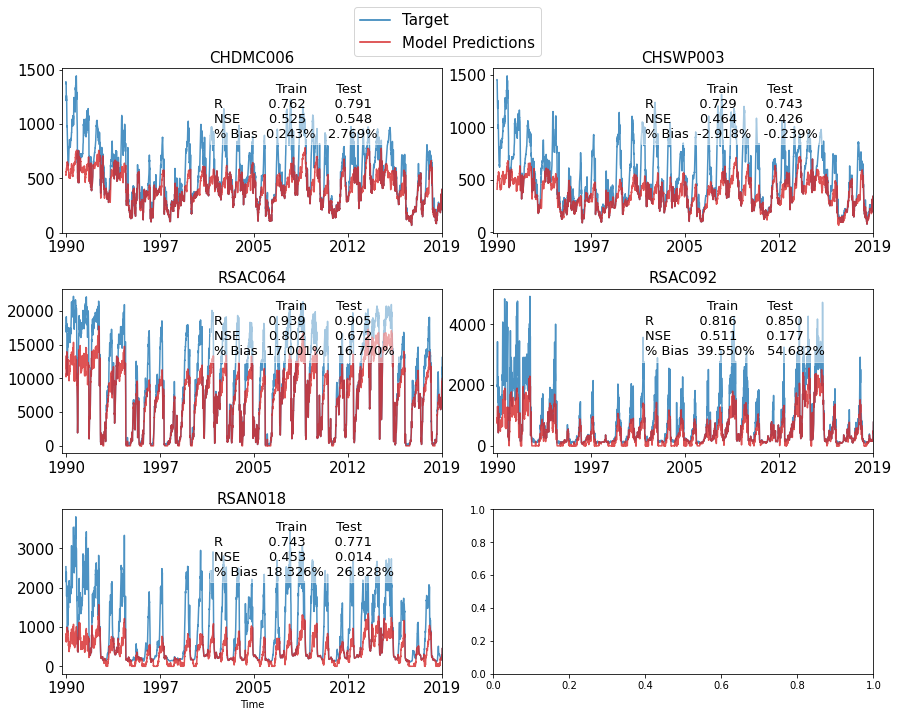

In [ ]:
test_data['baseline'] = "dsm2_ann_inputs_base.xlsx"
test_data['observed'] = "observed_data_daily.xlsx"

if save_results:
    from matplotlib import ticker
    import matplotlib.dates as mdates
    from matplotlib.lines import Line2D
    myfontsize=15
    ncols=2
    print('Testing MTL ANN for %d stations: ' % len(output_stations),end='')

    print([station.replace('target/','').replace('target','') for station in output_stations],end='\n')
    model_path_prefix = "mtl_%s_%s" % ('i%d_'%(ndays + nwindows) +model_str_def, scenario_name)

    annmodel = annutils.load_model(os.path.join(gdrive_root_path,'models', model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})

    for test_scenario, data_file in test_data.items():
        fig_savepath = os.path.join(gdrive_root_path,"images/%s_%s_time_series.png"% (model_path_prefix, test_scenario))
        print('Scenario: %s' % test_scenario)
        data_path = os.path.join(gdrive_root_path,data_file)

        dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

        df_inpout = pd.concat(dflist[0:num_sheets],axis=1).dropna(axis=0)
        dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
        dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)]
        dfouts = dfouts.rename(columns=name_mapping)[output_stations]
        
        fig_timeseries, ax_timeseries = plt.subplots(nrows=len(key_stations)//ncols,
                                                                    ncols=ncols,
                                                                    figsize=(6*ncols,3*len(key_stations)//ncols))
        fig_timeseries.tight_layout(h_pad=3.5, w_pad=2)
        ii = 0

        ## test results
        dfp=annutils.predict(annmodel.model, dfinps, annmodel.xscaler, annmodel.yscaler,columns=output_stations,
                            ndays=ndays,window_size=window_size,nwindows=nwindows,verbose=0)
        selected_key_stations = []
        for location in output_stations:
            if any([k.lower() in location.lower() for k in key_stations]):
                selected_key_stations.append(location)

        for location in selected_key_stations:
            if any([k.lower() in location.lower() for k in key_stations]):
                simplified_station_name = location.split('-')[0].replace('_',' ').replace('-',' ')
                simplified_station_name = key_station_mappings.get(simplified_station_name) or simplified_station_name
                y = dfouts.loc[:,location].copy()
                y[y<0] = float('nan')

                # Time Series Plots on Ground Truths vs. Model Predictions
                ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].plot(y.iloc[(ndays+nwindows*window_size-1):],'-',color='C0',alpha=0.8)
                ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].plot(dfp.loc[:,location].clip(0,y.iloc[(ndays+nwindows*window_size-1):]),'-',color='C3',alpha=0.8)
                if ii == ncols:
                    custom_lines = [Line2D([0], [0], color='C0'),
                                    Line2D([0], [0], color='C3')]
                    
                    ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].legend(custom_lines,
                                                                                    ['Target','Model Predictions'],
                                                                                    bbox_to_anchor=(1.28, 2.76),
                                                                                    fontsize=myfontsize)
                

                ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].set_title(simplified_station_name,fontsize=myfontsize)
                ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].set_xticks(pd.date_range(start=dfp.index[0],
                                                                                            end=dfp.index[-1],
                                                                                            periods=5))
                ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
                ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].set_xlim([dfinps.index[0], dfinps.index[-1]])
                ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].tick_params(axis='x', labelsize=myfontsize)
                ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].tick_params(axis='y', labelsize=myfontsize)
                t = ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].text(dfinps.index[int(dfinps.shape[0]*0.4)],
                            ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].get_ylim()[1]*0.58,
                            '               Train       Test\nR           %.3f       %.3f\nNSE       %.3f       %.3f\n%% Bias  %.3f%%   %.3f%%' % (full_results['%s_train' %location]['R'],
                                                                    full_results['%s_test' %location]['R'],
                                                                    full_results['%s_train' %location]['NSE'],
                                                                    full_results['%s_test' %location]['NSE'],
                                                                    full_results['%s_train' %location]['Bias'],
                                                                    full_results['%s_test' %location]['Bias']),
                            fontsize=myfontsize-2)
                t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
                if ii >= len(key_stations) - ncols:
                    ax_timeseries[ii//ncols,int(ii-(ii//ncols)*ncols)].set_xlabel('Time')
                ii += 1
        fig_timeseries.savefig(fig_savepath,bbox_inches='tight',dpi=300)
        print('Figure saved as %s' % fig_savepath)

In [ ]:
pd.date_range(start=dfp.index[0],end=dfp.index[-1],freq='5A')#,periods=5)

DatetimeIndex(['1990-12-31', '1995-12-31', '2000-12-31', '2005-12-31',
               '2010-12-31', '2015-12-31'],
              dtype='datetime64[ns]', freq='5A-DEC')